## Week 7 Video Notebook: Ensemble Methods -- Random Forests

This notebook accompanies the Week 7 video on Random Forests. The intent is to provide a baseline of techniques for implementing Random Forests, showing examples on a real dataset and providing template code for developing your own projects. 

In order to streamline the presentation for a short video, I will mostly show code for the majority of the notebook, and provide an Appendix at the end with discussion of the best practices for choosing parameters and tuning your model. 

In [2]:
# useful imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV,LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# globals

random_state = 42

# utility code

def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

# To avoid constant warnings about jobs: 
#        UserWarning: A worker stopped while some jobs were given to the executor. 
#        This can be caused by a too short worker timeout or by a memory leak.

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
# Load the California Housing Dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target


X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [5]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


In [43]:
# Wrapper function to simplify experiments with RF models

def run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 100,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,       
                                bootstrap = True,         
                                random_state = random_state,
                                cv=5,
                                ccp_alpha=0.0,
                                n_jobs=-1
                               ):
    
    rf_model = RandomForestRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        max_samples = max_samples,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        max_features = max_features,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap = bootstrap,
        n_jobs = n_jobs,              # use all possible cores
        random_state = random_state,
        ccp_alpha=ccp_alpha,
    )
    
    # Perform cross-validation
    neg_mse_scores = cross_val_score(
        rf_model, X_train, y_train, 
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=n_jobs
    )

    mean_cv_mse = -np.mean(neg_mse_scores)  # Convert to positive MSE
    return mean_cv_mse



In [44]:
run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 100,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               )


0.26166638798324254

### Your Turn!

As usual, you should play around with this a bit before proceeding. It is worth trying various values of `n_estimators`
and seeing that random forests typically do well with large numbers of estimators, so play around with this parameter: you should
see the MSE decrease as you increase this parameter, and eventually decrease. Don't worry about the other parameters yet. 

100%|███████████████████████████████████████████| 20/20 [06:02<00:00, 18.13s/it]


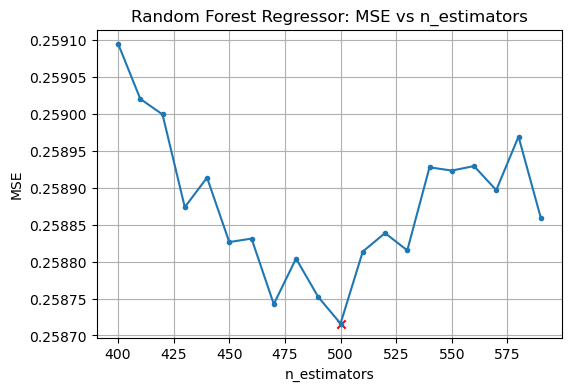

Minimum MSE 0.2587 found at x = 500
Execution Time: 6m 2.80s


In [47]:
# Plot a n_estimators vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'n_estimators'  

# parameter_list = range(400,1000,50) 
parameter_list = range(400,600,10)      

MSEs = []

for n in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = n,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 


                            
# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████████| 17/17 [04:01<00:00, 14.20s/it]


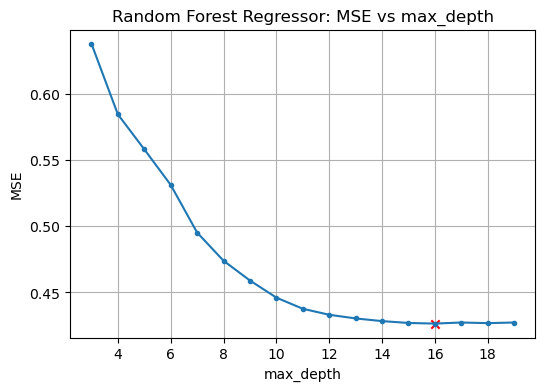

Minimum MSE 0.4263 found at x = 16
Execution Time: 4m 1.52s


In [36]:
# Plot a max_depth vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_depth'  

parameter_list = range(3,20)             # be sure to compare this with the default None

MSEs = []

for md in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 500,       
                                max_depth = md,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 
     

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

Hm... given the shape of the curve, the small improvement, and the best practices described below, I'm
going to stick with None (unlimited). We can check back later on this....

100%|███████████████████████████████████████████| 13/13 [03:18<00:00, 15.24s/it]


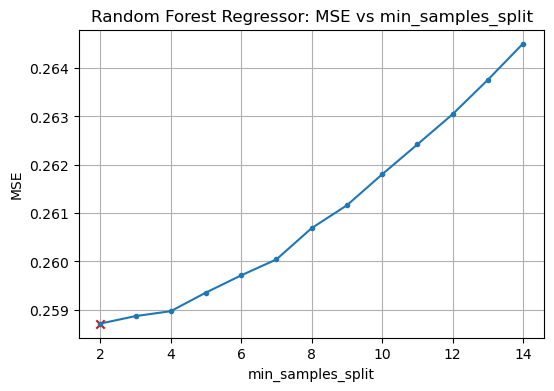

Minimum MSE 0.2587 found at x = 2
Execution Time: 3m 18.20s


In [48]:
# Plot a min_samples_split vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'min_samples_split'  

parameter_list = range(2,15)
# parameter_list = range(9,15)

MSEs = []

for mss in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 500,       
                                max_depth = None,         
                                min_samples_split = mss,    
                                min_samples_leaf = 1,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 
    

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|█████████████████████████████████████████████| 4/4 [00:59<00:00, 14.77s/it]


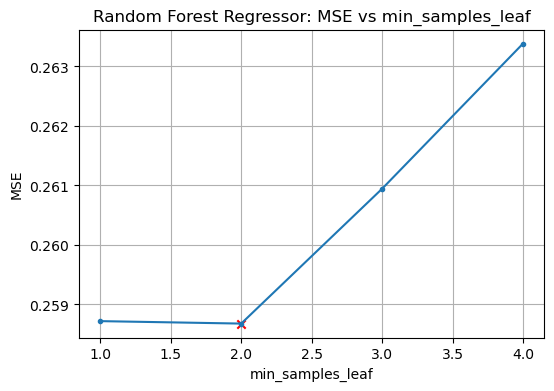

Minimum MSE 0.2587 found at x = 2
Execution Time: 59.21s


In [49]:
# Plot a min_samples_leaf vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'min_samples_leaf'  

parameter_list = range(1,5)      

MSEs = []

for msl in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 500,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = msl,     
                                max_samples = None,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) )

     

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████████| 11/11 [02:16<00:00, 12.41s/it]


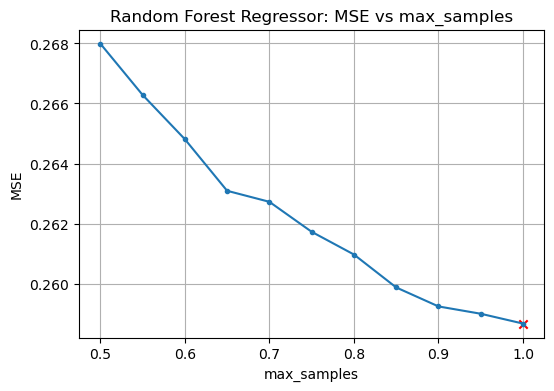

Minimum MSE 0.2587 found at x = 1.0000
Execution Time: 2m 16.66s


In [54]:
# Plot a max_samples vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_samples'  

parameter_list = np.linspace(0.5,1.0,11)  




MSEs = []

for ms in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 500,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 2,     
                                max_samples = ms,       
                                max_leaf_nodes=None,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 
     

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

100%|███████████████████████████████████████████| 31/31 [06:37<00:00, 12.82s/it]


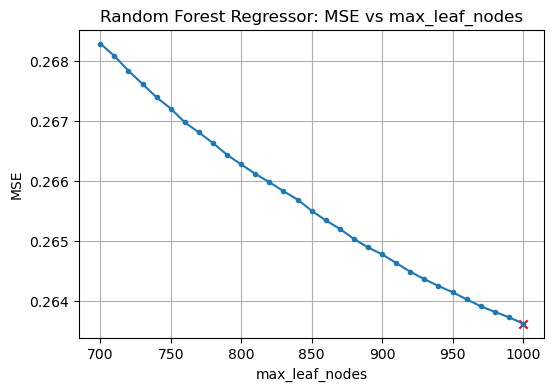

Minimum MSE 0.2636 found at x = 1000
Execution Time: 6m 37.47s


In [56]:
# Plot a max_leaf_nodes vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_leaf_nodes'  

parameter_list = range(700,1001,10)     

MSEs = []

for mls in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 500,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 2,     
                                max_samples = 1.0,       
                                max_leaf_nodes=mls,
                                max_features = 1.0,             
                                ccp_alpha=0.0,
                               ) ) 
     

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

Ok, as with max_depth, I don't see any reason to choose a value other than the default None (no limits). Random forests tend to do better at managing depth and size than the previous models we have explored. 

100%|█████████████████████████████████████████████| 8/8 [01:13<00:00,  9.14s/it]


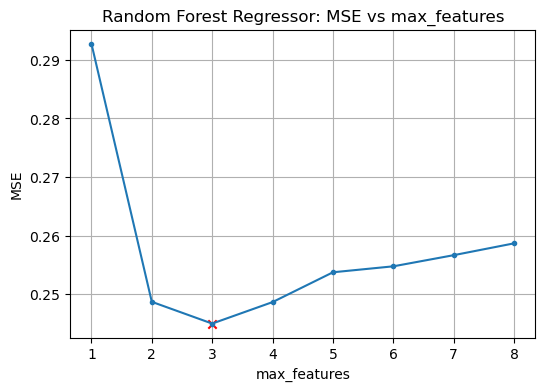

Minimum MSE 0.2450 found at x = 3
Execution Time: 1m 13.23s


In [63]:
# Plot a max_features vs MSE using a simple for loop

# record beginning time
start = time.time()

param = 'max_features'  

parameter_list = range(1,9)


MSEs = []

for mf in tqdm(parameter_list):

    MSEs.append( run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 500,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 2,     
                                max_samples = 1.0,       
                                max_leaf_nodes=None,
                                max_features = mf,             
                                ccp_alpha=0.0,
                               ) ) 
     

# Find the minimum value
min_MSE = min(MSEs)

# Find the index of the minimum value
min_index = MSEs.index(min_MSE)

plt.figure(figsize=(6, 4))
plt.title("Random Forest Regressor: MSE vs "+param)
plt.plot(parameter_list, MSEs, marker='.')
plt.scatter([parameter_list[min_index]],[min_MSE],marker='x',color='red')
plt.xlabel(param)
plt.ylabel("MSE")
plt.grid()
plt.show()

if isinstance(parameter_list[min_index], int):
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]}")
else:
    print(f"Minimum MSE {min_MSE:.4f} found at x = {parameter_list[min_index]:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))

Ok, let's summarize after one round:

- The three parameters max_depth, max_leaf_nodes, and max_samples are unlikely to change; this is to be expected with random forests because they inherently rely on randomness in feature selection and tree structure, and these parameters primarily control the individual trees rather than the overall ensemble behavior.

- Therefore, in the second round, we can simply concentrate on the other parameters.

- After one more round, I found the following "optimal" parameters shown in the next code cell. 

In [86]:
run_random_forest_regressor(X_train, y_train, 
                                n_estimators = 971,       
                                max_depth = None,         
                                min_samples_split = 2,    
                                min_samples_leaf = 1,     
                                max_samples = 1.0,       
                                max_leaf_nodes=None,
                                max_features = 3,             
                                ccp_alpha=0.0,            
                               )

0.24196196848299006

## Final Exam!

In [79]:
rf_model = RandomForestRegressor(
    n_estimators = 971,
    max_depth = None,
    max_samples = 1.0,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 3,
    max_leaf_nodes=None
)

   
rf_model.fit(X_train,y_train)

y_test_pred = rf_model.predict(X_test)

test_MSE = mean_squared_error(y_test_pred,y_test)

print(f"Test MSE: {test_MSE:.4f}")

Test MSE: 0.2397


### Your Turn!

To refine or confirm the parameter settings, expand the list of parameter values below and check a bit
around the values of the three parameters shown, which are the only ones to move around a bit during
the two rounds of testing above. 


### Grid Search

On to grid search to confirm!  It seems pretty clear that the only features to refine are `n_estimators` and `max_features`.  Just to be sure, let's also check on `min_samples_leaf`; my intuition (and the shape of the curve) is that the default is probably better here, but let's check to be sure. 

In [89]:
# Run GridSearchCV

# Record start time
start = time.time()

# Define the model
rf_model = RandomForestRegressor(random_state=random_state)

# Define the parameter grid
param_dist = {
    'n_estimators':     [971],
    'min_samples_leaf': [1],
    'max_features':     [3]
}

# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=5,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Fit the GridSearchCV
search.fit(X_train, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_min_samples_leaf',
    'param_max_features',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_min_samples_leaf': 'min_samples_leaf',
        'param_max_features': 'max_samples',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV MSE: {-search.best_score_:.4f}")

# Evaluate on the test set
y_pred_rf = search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_rf)

print(f"Test MSE:    {test_mse:.4f}")

# Record end time and execution time
end = time.time()
print(f"Execution Time: " + format_time(end-start))



Search Results (Top 5):

n_estimators min_samples_leaf max_samples  mean_cv_score  std_cv_score  mean_train_score  std_train_score
         971                1           3       0.241962      0.003976          0.032838         0.000137

Best Parameters: {'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 971}
Best CV MSE: 0.2420
Test MSE:    0.2379
Execution Time: 1m 24.95s


## Appendix 

### **Most Significant Parameters and Best Practices for `RandomForestRegressor`**

---

- **`n_estimators`** (int), default=100  
  The number of trees in the forest.  
  - **Best Practices**:  
    - Start with the default (`100`) and increase incrementally for larger datasets or to stabilize predictions.  
    - Be mindful of diminishing returns as `n_estimators` increases, which may not justify additional computational cost.

---

- **`criterion`** ({"squared_error", "friedman_mse", "absolute_error"}), default="squared_error"  
  Controls how the decision tree measures the quality of splits during its construction.  
    - **“squared_error”**: Minimizes the L2 loss using the mean of each terminal node.  
    - **“friedman_mse”**: A refinement of squared error, often slightly better for regression tasks.  
    - **“absolute_error”**: Minimizes the L1 loss using the median of each terminal node but is computationally expensive.  
  - **Best Practices**:  
    - Use the default (`squared_error`) for most tasks.  
    - Consider `friedman_mse` for slight performance improvements in regression.  
    - Avoid `absolute_error` unless L1 loss is explicitly required.

---

- **`max_depth`** (int or None), default=None  
  The maximum depth of the trees. If None, nodes are expanded until all leaves are pure or contain fewer than `min_samples_split` samples.  
  - **Best Practices**: 
  
       - Start with None (unlimited depth) for initial exploration, as random forests mitigate overfitting due to their ensemble averaging.
        
       - Reduce to a fixed value (e.g., 10–20) if computational efficiency is a concern or if overfitting persists despite the ensemble nature of the model.
        
       - Experiment with smaller values (e.g., 5–15) for noisy or small datasets, where deep trees may capture noise rather than true patterns.

---

- **`min_samples_split`** (int or float), default=2  
  The minimum number of samples required to split an internal node.  
  - **Best Practices**:  
    - Use the default (`2`) for most tasks.  
    - Increase this value (e.g., `5–10`) for larger datasets or to prevent overly deep trees and overfitting.

---

- **`min_samples_leaf`** (int or float), default=1  
  The minimum number of samples required to be at a leaf node. A split at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches.  
  - **Best Practices**:  
    - Start with the default (`1`) and increase if overfitting occurs. Larger values (e.g., `5–10`) smooth predictions and reduce variance.  
    - For larger datasets, consider using a fraction (e.g., `0.01`) to adapt the value to dataset size.

---

- **`max_samples`** (int or float), default=None  
  If bootstrap is True (the default), the number of samples to draw from X to train each base estimator. Samples are drawn with replacement by default in random forests.  
  
  
  - **Best Practices:**  
      - If None (default), each tree is trained on a bootstrap sample of the entire dataset. This works well in most cases.  
      - For large datasets or to introduce more randomness, consider using a fraction of the dataset (e.g., `0.8` or `0.66`) to train each tree.  
      - Reducing `max_samples` can help improve computational efficiency when training on very large datasets.

    
---

- **`max_features`** ({"sqrt", "log2", int, float, None}), default=1.0  
  The number of features to consider when looking for the best split:  
    - **“sqrt”**: Square root of the total number of features (default).  
    - **“log2”**: Log base 2 of the total number of features.  
    - **None**: Use all features.  
  - **Best Practices**:  
    - Use `"sqrt"` for most regression tasks to balance randomness and accuracy.  
    - Smaller values (e.g., `"log2"`) reduce overfitting and improve diversity among trees.  
    - Larger values (e.g., `None`) may improve accuracy but risk overfitting.

---

- **`max_leaf_nodes`** (int), default=None  
  Grow trees with a maximum number of leaf nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None, the number of leaf nodes is unlimited.  
  - **Best Practices**:  
    - Leave as `None` initially and adjust only if overfitting is observed.  
    - Use smaller values (e.g., `50–500`) for better generalization, especially on noisy datasets.

---


- **`ccp_alpha`** {float}, default=0.0.  Complexity parameter used for Minimal Cost-Complexity Pruning. The larger the `ccp_alpha`, the more aggressive the pruning.

  - **Best Practices:**
      - Random forests typically use fully grown trees by default, so `ccp_alpha` is less commonly used in this context.
      - If you observe overfitting in your random forest model, consider applying pruning with `ccp_alpha` to individual trees as an advanced technique.
      - Use **`GridSearchCV`** or **cross-validation** to find the optimal value of `ccp_alpha` for your dataset.
      - Start with small values (e.g., 0.001 or 0.01) and gradually increase to balance tree complexity and performance.
      - Be aware that pruning individual trees may slightly reduce the strength of the ensemble but can help in datasets prone to noise or overfitting.
